In [1]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(dplyr)
    library(tidyr)
    library(monocle3)
    library(Seurat)
})

# Ko preprocessing

In [8]:
create_cds_from_10x_dir <- function(mtx_dir, condition=NULL) {
    mtx <- as.matrix(Matrix::readMM(file.path(mtx_dir, 'matrix.mtx')))
    bcs <- readLines(file.path(mtx_dir, 'barcodes.tsv'))
    genes <- read.table(file.path(mtx_dir, 'features.tsv'), sep='\t', header=FALSE,
                        stringsAsFactors=FALSE)
    genes <- genes[[1]]
    rownames(mtx) <- genes
    colnames(mtx) <- bcs
    if (!is.null(condition)) {
        condition <- rep(condition, length(bcs))
        cell_meta <- data.frame(condition, row.names=bcs)
        colnames(cell_meta) <- c('condition')
    } else {
        cell_meta <- data.frame(row.names=bcs)
    }
    gene_meta <- as.data.frame(genes)
    rownames(gene_meta) <- genes
    colnames(gene_meta) <- c('gene_short_name')
    cds <- new_cell_data_set(mtx, cell_meta, gene_meta)
    return(cds)
}

In [3]:
data_dir <- '/home/6j9/projects/atopic_dermatitis/data'
mtx_dirs <- list.files(file.path(data_dir, 'count_matrices/ko'), full.names=TRUE)
conditions <- c('healthy', 'healthy', 'ad', 'ad', 'ad')

In [4]:
all_cds <- list()
for (i in seq_along(mtx_dirs)) {
     all_cds[[i]] <- create_cds_from_10x_dir(mtx_dirs[[i]], conditions[[i]])
}
cds <- combine_cds(all_cds, cell_names_unique=TRUE)
# remove genes expressed in fewer than 10 cells
genes_to_keep <- apply(counts(cds), 1, function(x) sum(x != 0) >= 10)
cds <- cds[genes_to_keep, ]

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.4 GiB”


In [5]:
# change samples to factors so they can plot correctly
metadata <- colData(cds)
metadata$sample <- as.factor(metadata$sample)
colData(cds) <- metadata

# Ko clustering

In [6]:
plot_dir <- '/home/6j9/projects/atopic_dermatitis/plots'

In [7]:
# cluster using monocle3
cds <- preprocess_cds(cds, num_dim=50, norm_method='log')
cds <- align_cds(cds, num_dim=100, alignment_group='sample')
cds <- reduce_dimension(cds, max_components=2, reduction_method='UMAP')

Aligning cells from different batches using Batchelor.
Please remember to cite:
	 Haghverdi L, Lun ATL, Morgan MD, Marioni JC (2018). 'Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.' Nat. Biotechnol., 36(5), 421-427. doi: 10.1038/nbt.4091

No preprocess_method specified, and aligned coordinates have been computed previously. Using preprocess_method = 'Aligned'



No trajectory to plot. Has learn_graph() been called yet?

Saving 7 x 7 in image


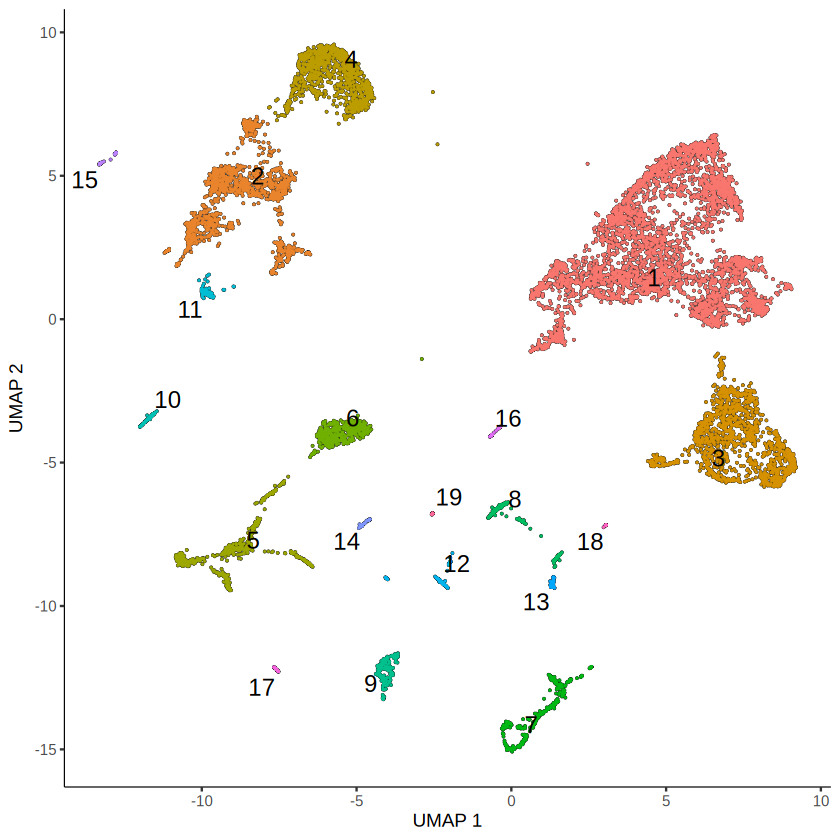

In [8]:
cds <- cluster_cells(cds, reduction_method='UMAP', cluster_method='leiden', resolution=0.00001)
plot_cells(cds, group_label_size=5)
ggsave(file.path(plot_dir, 'cells/clusters.png'))

No trajectory to plot. Has learn_graph() been called yet?

Saving 7 x 7 in image


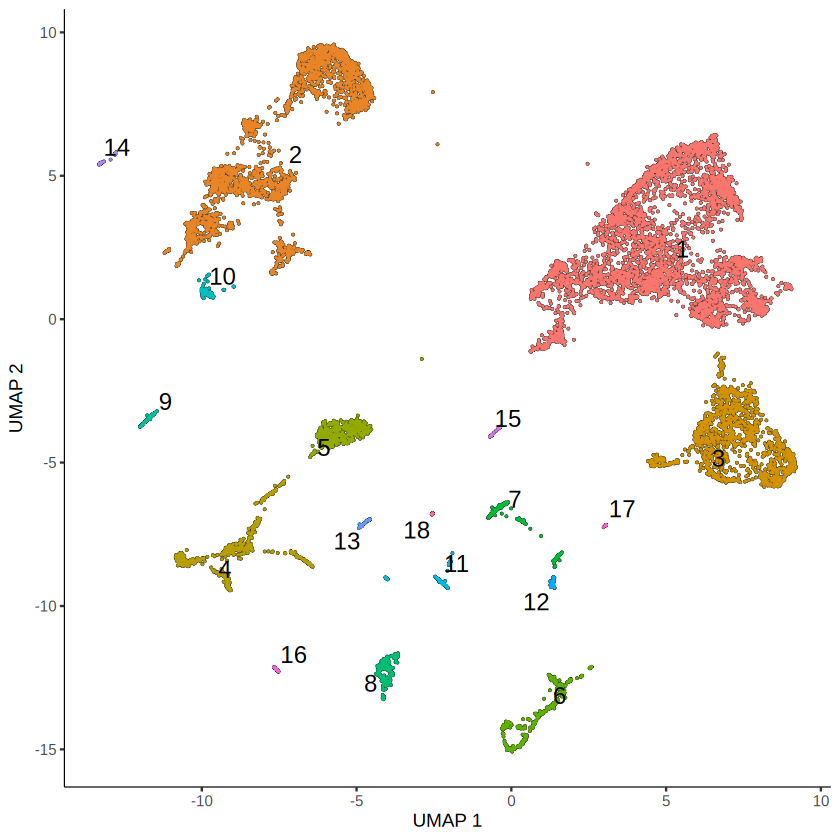

In [9]:
plot_cells(cds, color_cells_by='partition', group_cells_by='partition',
           group_label_size=5)
ggsave(file.path(plot_dir, 'cells/partitions.png'))

No trajectory to plot. Has learn_graph() been called yet?

Saving 7 x 7 in image


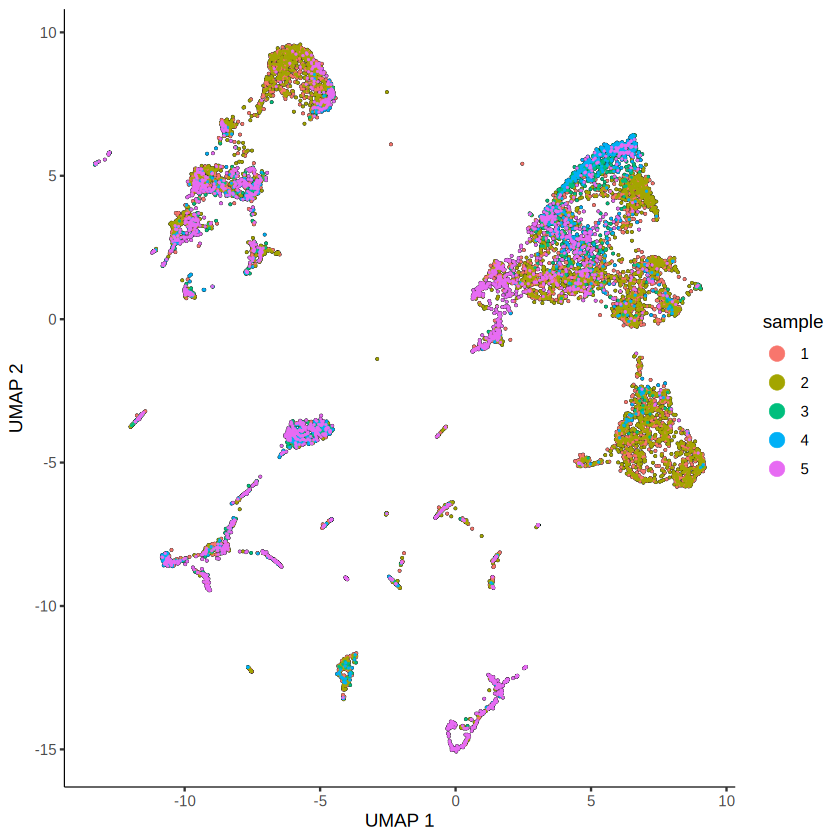

In [11]:
plot_cells(cds, color_cells_by='sample', label_cell_groups=FALSE)
ggsave(file.path(plot_dir, 'cells/samples.png'))

No trajectory to plot. Has learn_graph() been called yet?

Saving 7 x 7 in image


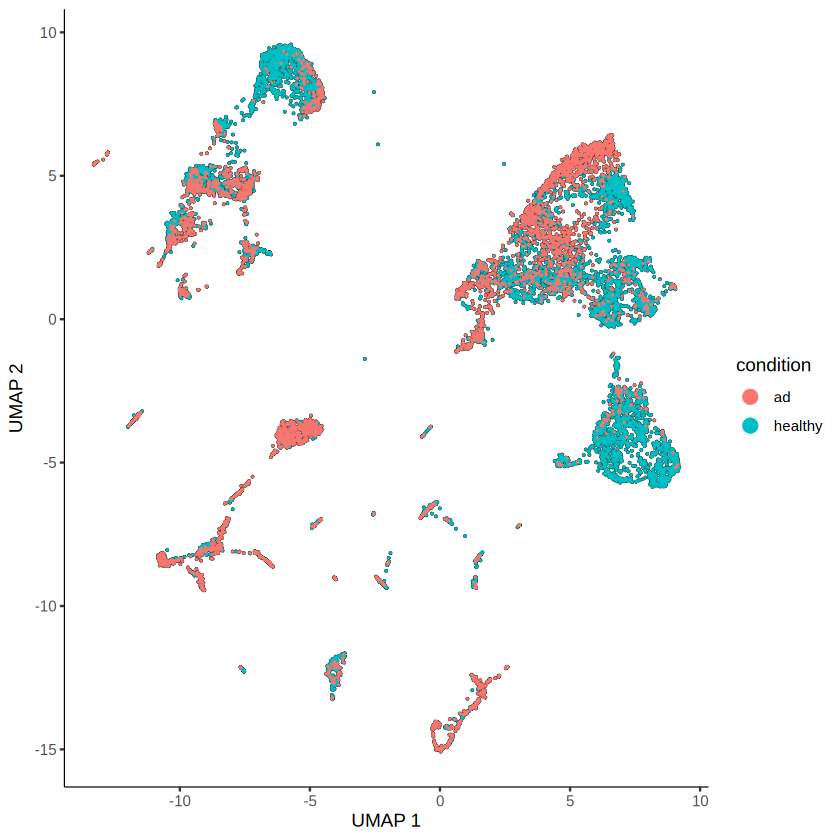

In [12]:
plot_cells(cds, color_cells_by='condition', label_cell_groups=FALSE)
ggsave(file.path(plot_dir, 'cells/conditions.png'))

# Ko cell typing

In [13]:
# get top marker genes per partition
markers <- top_markers(cds, group_cells_by='partition',
                       genes_to_test_per_group=100,
                       reduction_method='UMAP', cores=12)

'as(<lgCMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "dMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



  |=======================================================| 100%, Elapsed 00:02
  |=======================================================| 100%, Elapsed 00:32


In [14]:
head(markers)

gene_id  gene_short_name cell_group marker_score mean_expression
1 SOX17    SOX17           7          0.2774911    0.8192177      
2 MSC      MSC             11         0.1282669    0.3638145      
3 SBSPON   SBSPON          15         0.1482892    1.4672661      
4 SBSPON   SBSPON          18         0.1900407    1.4392503      
5 CRISPLD1 CRISPLD1        3          0.2713689    0.6096405      
6 DST      DST             15         0.1760789    1.9390606      
  fraction_expressing specificity pseudo_R2  marker_test_p_value
1 0.3416667           0.8121691   0.28901203 3.308867e-135      
2 0.2127660           0.6028543   0.09290444  1.599126e-22      
3 0.4193548           0.3536126   0.21486244  3.007296e-21      
4 0.5454545           0.3484080   0.25786010  2.954652e-19      
5 0.4664765           0.5817419   0.24603256  0.000000e+00      
6 0.5806452           0.3032470   0.11359590  6.269344e-12      
  marker_test_q_value
1 1.086308e-129      
2  5.249963e-17      
3  9.873012e-16      
4  9.700183e-14      
5  0.000000e+00      
6  2.058238e-06

In [15]:
# manually remove genes that are expressed across
# all celltypes and show up in the dot plots
to_remove <- c('CST3', 'LGALS1', 'DBI', 'CD9')
markers <- markers %>% filter(!(gene_id %in% to_remove))
top_markers <- markers %>%
                    filter(specificity >= 0.33) %>%
                    group_by(cell_group) %>%
                    top_n(6, pseudo_R2)
marker_ids <- unique(top_markers$gene_id)

In [16]:
out_path <- file.path(plot_dir, 'genes/partition_genes_dotplot.png')
plot <- plot_genes_by_group(cds,
                            markers=marker_ids,
                            group_cells_by='partition',
                            ordering_type='cluster_row_col',
                            max.size=3)
ggsave(out_path, plot, width=8, height=12)

In [17]:
# adding partition cell types
colData(cds)$partition_cell_type <- as.character(partitions(cds))
colData(cds)$partition_cell_type <- dplyr::recode(colData(cds)$partition_cell_type,
                                                  '1'='Fibroblasts 1',
                                                  '2'='Mononuclear phagocytes',
                                                  '3'='Fibroblasts 2',
                                                  '4'='Natural killer cells',
                                                  '5'='Type 2 ILC2s',
                                                  '6'='Epithelial cells',
                                                  '7'='Endothelial cells',
                                                  '8'='Myocytes',
                                                  '9'='Mast cells',
                                                  '10'='cDC1s',
                                                  '11'='Myofibroblasts',
                                                  '12'='Smooth muscle cells',
                                                  '13'='B cells',
                                                  '14'='Neutrophils',
                                                  '15'='Schwann cells',
                                                  '16'='Keratinocytes',
                                                  '17'='Lymphatic ECs',
                                                  '18'='Basal cells')

No trajectory to plot. Has learn_graph() been called yet?



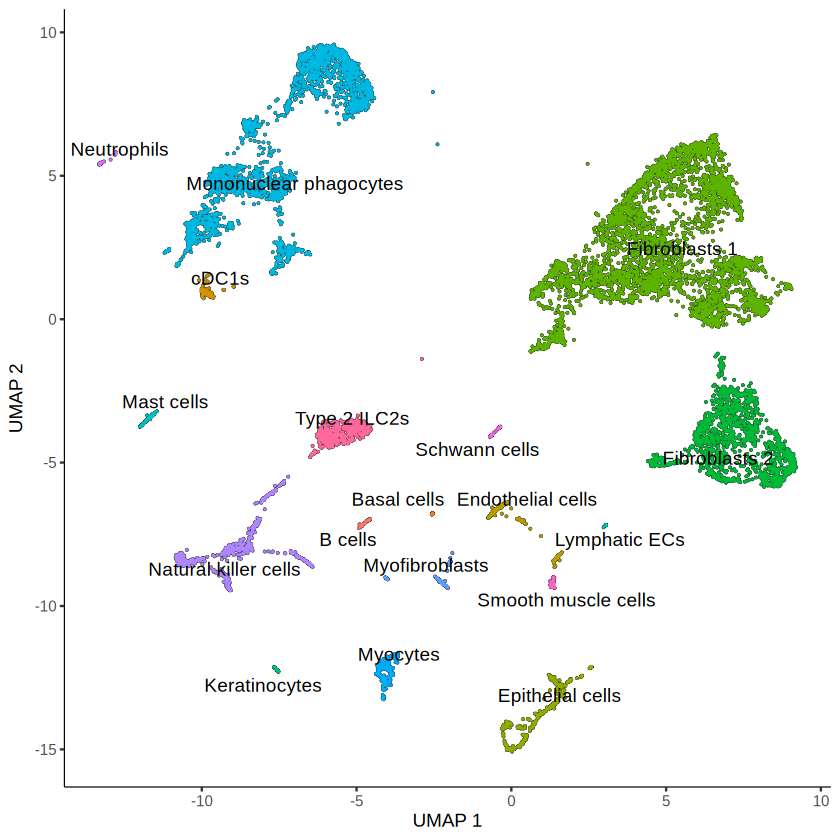

In [18]:
plot_cells(cds, color_cells_by='partition_cell_type', group_cells_by='partition',
           group_label_size=4)
ggsave(file.path(plot_dir, 'cells/cell-typed_partitions.png'), width=8, height=8)

# Ko Fibroblast Subpopulations

In [19]:
fibro_plot_dir <- file.path(plot_dir, 'cells/fibroblasts')

In [21]:
fibro <- cds[, partitions(cds) %in% c('1', '3')]

Saving 7 x 7 in image


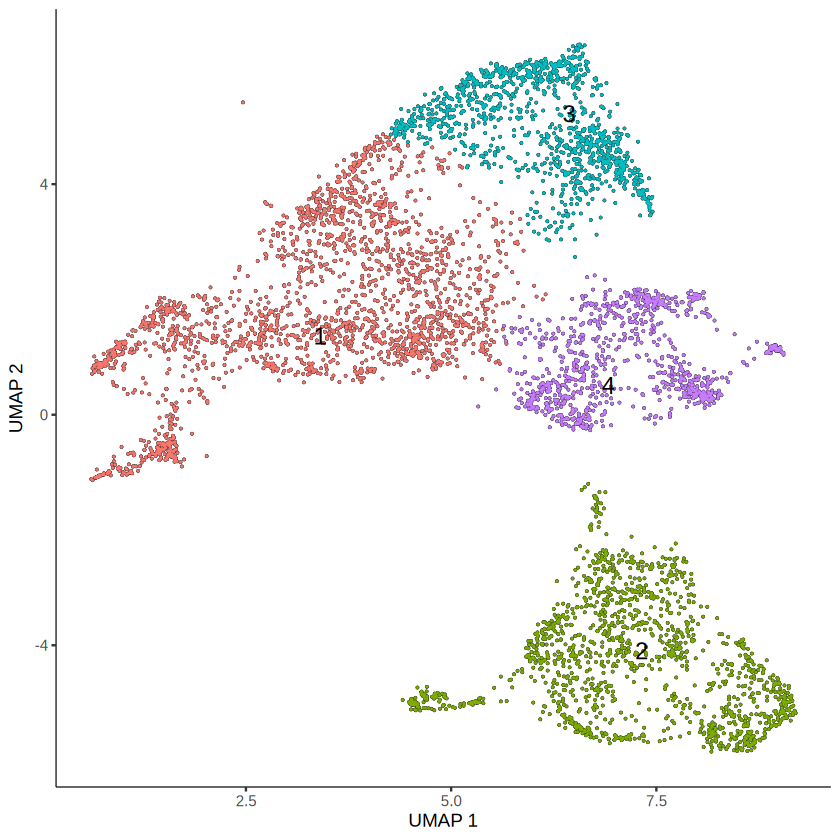

In [82]:
fibro <- cluster_cells(fibro, resolution=0.0002)
plot_cells(fibro, color_cells_by='cluster', group_label_size=5,
           show_trajectory_graph=FALSE)
ggsave(file.path(fibro_plot_dir, 'fibro_subclusters.png'))

In [ ]:
plot_cells(fibro, color_cells_by='condition', label_cell_groups=FALSE,
           show_trajectory_graph=FALSE)
ggsave(file.path(fibro_plot_dir, 'fibro_conditions.png'))

In [59]:
# get top marker genes per fibro cluster
markers <- top_markers(fibro, group_cells_by='cluster',
                       genes_to_test_per_group=1000, speedglm.maxiter=100,
                       reduction_method='UMAP', cores=12)

  |=======================================================| 100%, Elapsed 00:01
  |=======================================================| 100%, Elapsed 00:32


In [64]:
fibro_markers <- markers %>%
                    filter(specificity >= 0.5) %>%
                    #filter(fraction_expressing >= .9) %>%
                    group_by(cell_group) %>%
                    #top_n(16, mean_expression)
                    top_n(16, pseudo_R2)
marker_ids <- unique(fibro_markers$gene_id)

In [65]:
out_path <- file.path(fibro_plot_dir, 'fibro_genes_dotplot.png')
plot <- plot_genes_by_group(fibro,
                            markers=c(marker_ids),
                            group_cells_by='cluster',
                            ordering_type='cluster_row_col',
                            max.size=5)
ggsave(out_path, plot, width=8, height=12)

In [83]:
colData(fibro)$cluster_cell_type <- as.character(clusters(fibro))
colData(fibro)$cluster_cell_type <- dplyr::recode(colData(fibro)$cluster_cell_type,
                                                  '1'='Inflammatory fibroblasts 1',
                                                  '2'='Pericyte-like fibroblasts',
                                                  '3'='Inflammatory fibroblasts 2',
                                                  '4'='Normal fibroblasts')

In [84]:
# merge these fibroblast subtypes with the original cds
colData(cds)$subclustered_cell_type <- colData(cds)$partition_cell_type
colData(cds)[colnames(fibro), ]$subclustered_cell_type <- colData(fibro)$cluster_cell_type

No trajectory to plot. Has learn_graph() been called yet?



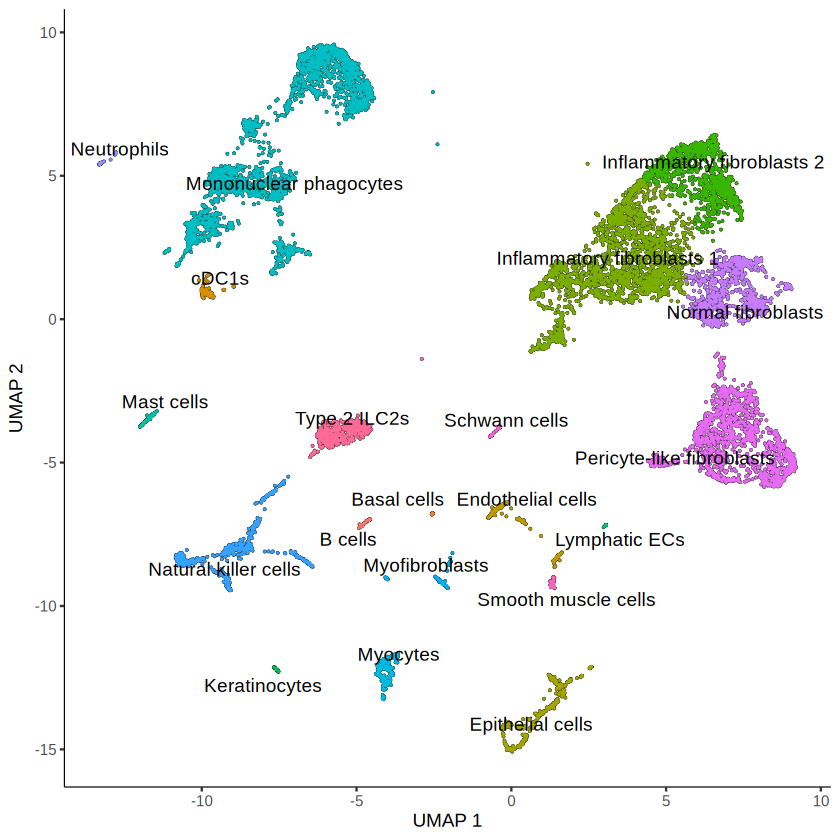

In [88]:
plot_cells(cds, color_cells_by='subclustered_cell_type', group_cells_by='partition',
           group_label_size=4, labels_per_group=3)
ggsave(file.path(plot_dir, 'cells/cell-typed_partition-subclusters.png'), width=8, height=8)

### Fibroblast Modules

In [526]:
fibro_umap_coords <- reducedDims(fibro)$UMAP
colnames(fibro_umap_coords) <- c('UMAP1', 'UMAP2')
fibro_graph_test <- graph_test(fibro, neighbor_graph='knn', cores=12)
fibro_deg_ids <- row.names(subset(fibro_graph_test,
                                  morans_I > 0.01 & q_value < 0.05))

  |=======================================================| 100%, Elapsed 01:17


In [527]:
# group fibro DEGs with similar expression patterns
fibro_modules <- find_gene_modules(fibro[fibro_deg_ids, ], resolution=0.001)
# convert to df
fibro_agg_gene_exp <- aggregate_gene_expression(fibro, gene_group_df=fibro_modules,
                                                scale_agg_values=TRUE)
fibro_agg_gene_exp <- t(fibro_agg_gene_exp)
fibro_agg_gene_exp <- cbind(fibro_agg_gene_exp, fibro_umap_coords)

In [713]:
# convert to long form to allow plotting with facet_wrap
fibro_agg_gene_exp_long <- as.data.frame(fibro_agg_gene_exp) %>%
    pivot_longer(cols=1:18, names_to='module', values_to='value')

In [540]:
# convert colors close to 0 to grey
fibro_agg_gene_exp_long <- fibro_agg_gene_exp_long %>%
    mutate(color_value=case_when(
        #value >= -0.5 & value <= 0.5 ~ NA,
        value <= 0 ~ NA,
        TRUE ~ as.numeric(value)
    ))

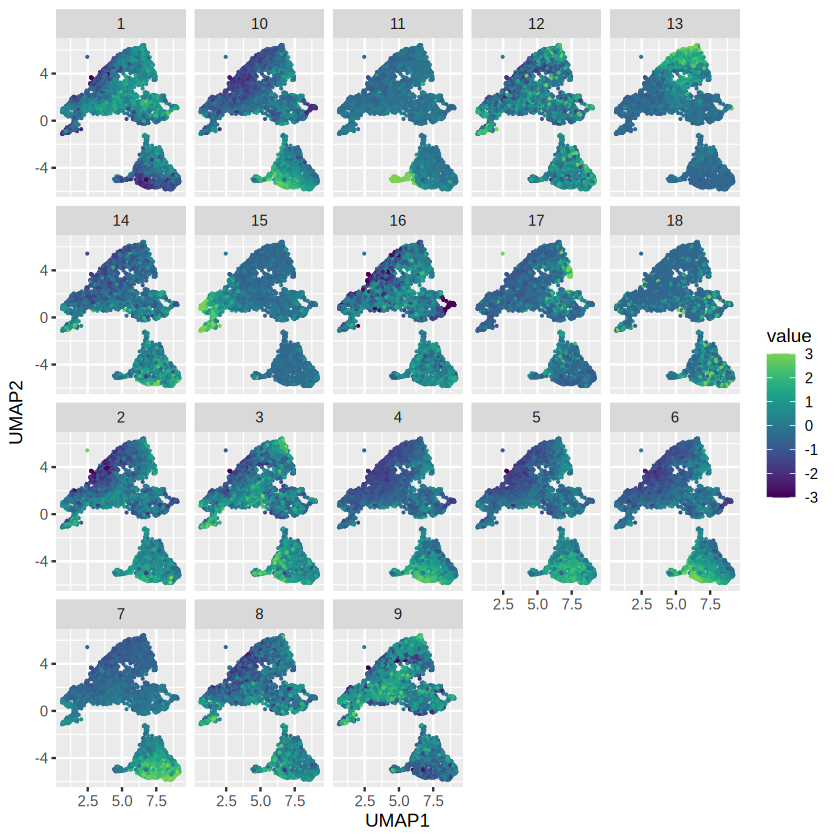

In [715]:
out_path <- file.path(fibro_plot_dir, 'agg_exp_modules.png')
#ggplot(data=fibro_agg_gene_exp_long, aes(x=UMAP1, y=UMAP2, color=color_value)) +
ggplot(data=fibro_agg_gene_exp_long, aes(x=UMAP1, y=UMAP2, color=value)) +
    geom_point(alpha=1, size=0.1) +
    viridis::scale_color_viridis(end=0.8, na.value='grey80') +
    facet_wrap(~ module)
ggsave(out_path, width=12, height=12)

In [717]:
head(fibro_modules)

id      module supermodule dim_1      dim_2     
1 MRPL15  10     1            0.7142846 -3.8381043
2 LYPLA1  10     1            0.6937291 -3.6761008
3 TCEA1   3      1            0.7957505  0.8479123
4 ATP6V1H 9      1            0.5033799  2.0512150
5 RB1CC1  9      1           -0.7904893  1.9980242
6 PCMTD1  3      1            0.2990327  1.2184026

In [720]:
out_modules_dir <- '/home/6j9/projects/atopic_dermatitis/data/monocle_degs'

In [725]:
writeLines(unique(fibro_modules$id), file.path(out_modules_dir, 'fibro_background_genes.txt'))

In [723]:
mod_13_degs <- fibro_modules %>% filter(module == 13)
mod_13_ids <- mod_13_degs$id
out_path <- file.path(out_modules_dir, 'mod-13.txt')
writeLines(mod_13_ids, out_path)

In [913]:
mod_15_degs <- fibro_modules %>% filter(module == 15)
mod_15_ids <- mod_15_degs$id
out_path <- file.path(out_modules_dir, 'mod-15.txt')
writeLines(mod_15_ids, out_path)

### Gene expression heatmaps

In [46]:
# collagens
collagens <- unique(grep("^COL", rownames(fibro), value=TRUE))
col_plot <- plot_cells(fibro, genes=collagens, label_cell_groups=FALSE,
           show_trajectory_graph=FALSE)
ggsave(plot=col_plot, file.path(fibro_plot_dir, 'collagens.png'))

Saving 7 x 7 in image


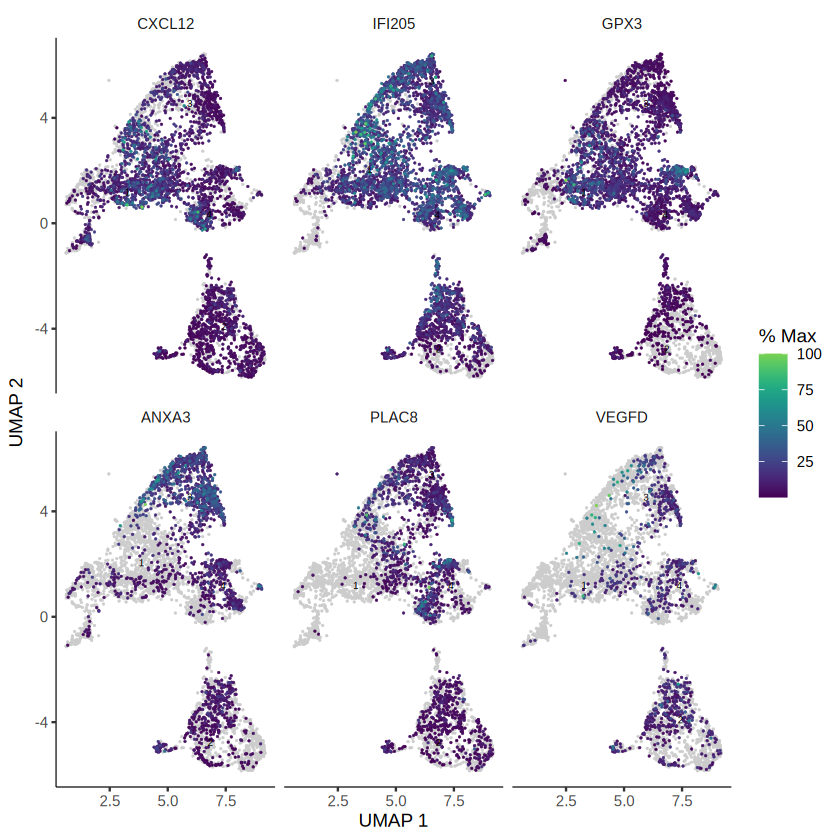

In [56]:
# cluster 1 - inflammatory fibroblasts 1
plot_cells(fibro, genes=c('CXCL12', 'IFI205', 'GPX3', 'ANXA3',
                          'PLAC8', 'CXCL18', 'VEGFD'),
           show_trajectory_graph=FALSE)

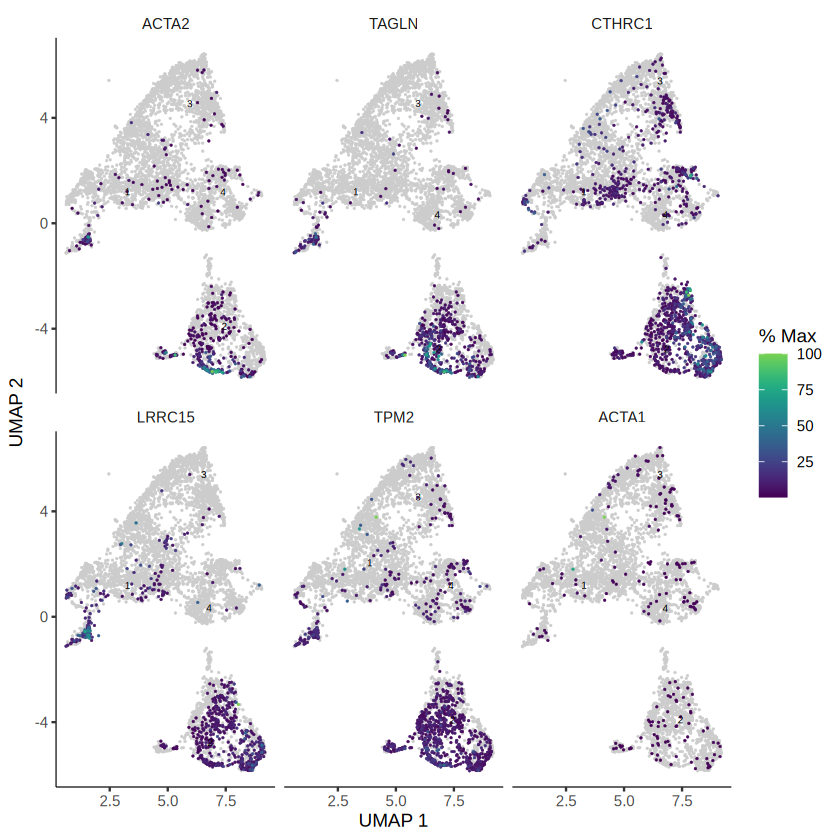

In [74]:
# cluster 2 - Pericyte-like fibroblasts
plot_cells(fibro, genes=c('ACTA2', 'TAGLN', 'CTHRC1', 'LRRC15', 'TPM2', 'ACTA1'),
           show_trajectory_graph=FALSE)

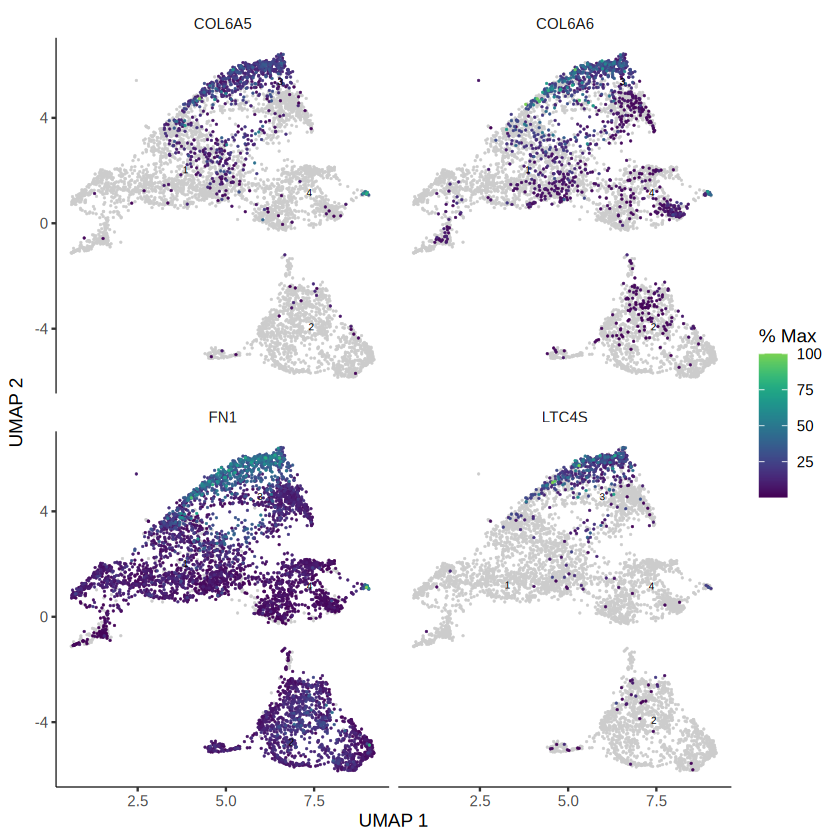

In [864]:
# cluster 3 - inflammatory fibroblasts 2
plot_cells(fibro, genes=c('COL6A5', 'COL6A6', 'FN1', 'LTC4S'),
           show_trajectory_graph=FALSE)

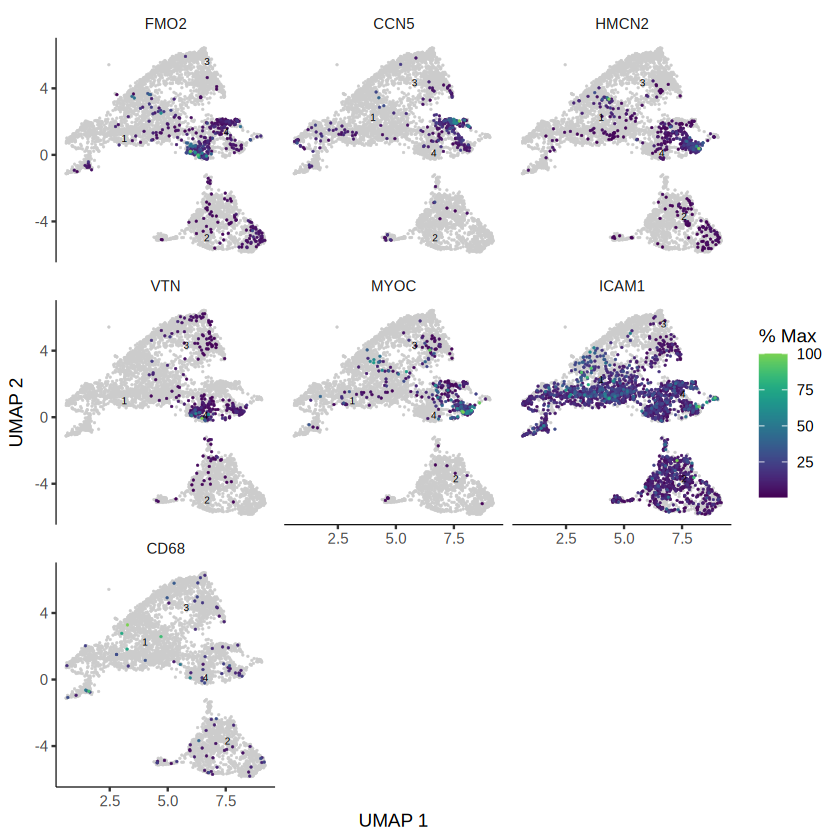

In [69]:
# cluster 4 - normal fibroblasts
plot_cells(fibro, genes=c('FMO2', 'CCN5', 'HMCN2', 'VTN', 'MYOC', 'ICAM1'),
           show_trajectory_graph=FALSE)

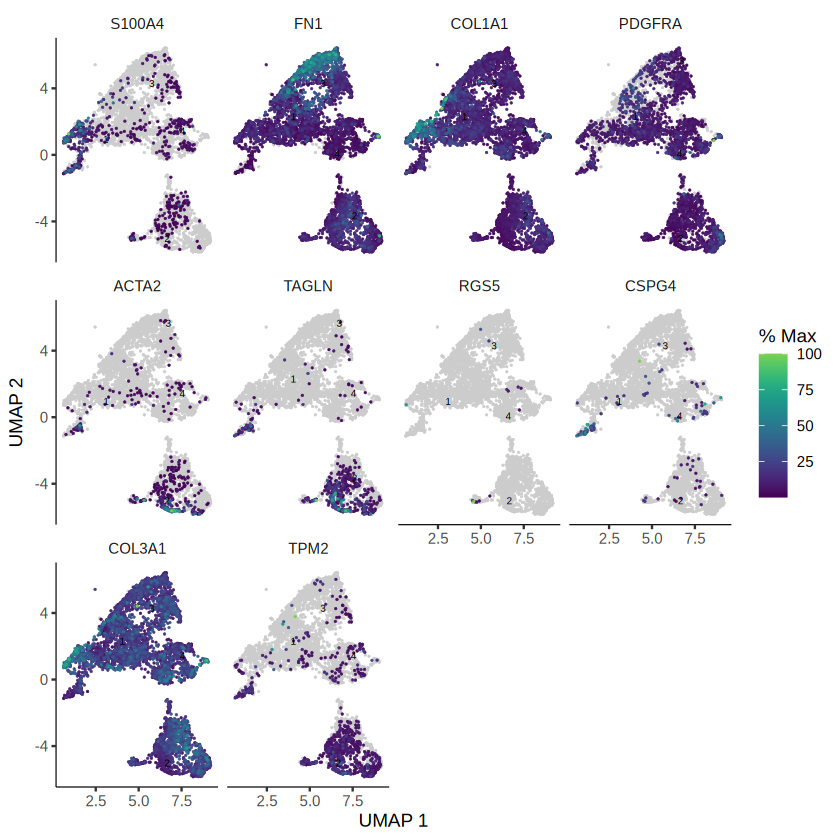

In [912]:
# tests 1
plot_cells(fibro, genes=c('S100A4', 'FN1', 'COL1A1', 'PDGFRA', 'ACTA2', 'TAGLN',
                          'RGS5', 'CSPG4', 'COL3A1', 'TPM2'),
           show_trajectory_graph=FALSE)

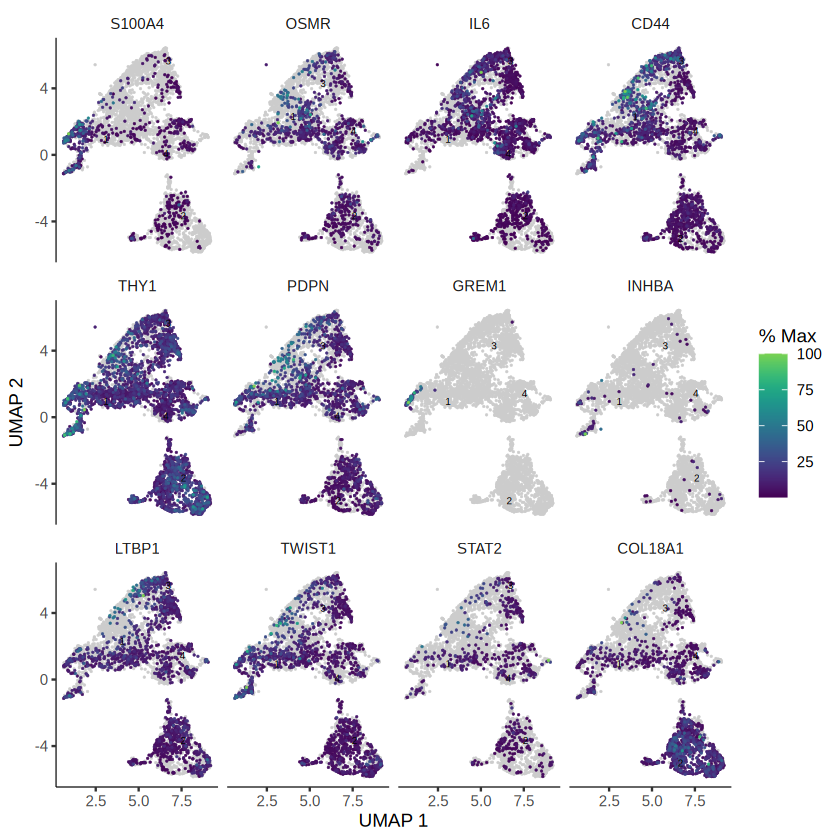

In [931]:
# tests 2
plot_cells(fibro, genes=c('S100A4', 'CXCL8', 'OSMR', 'IL6', 'CD44', 'THY1', 'PDPN',
                          'GREM1', 'INHBA', 'LTBP1', 'TWIST1', 'STAT2', 'COL18A1'),
           show_trajectory_graph=FALSE)

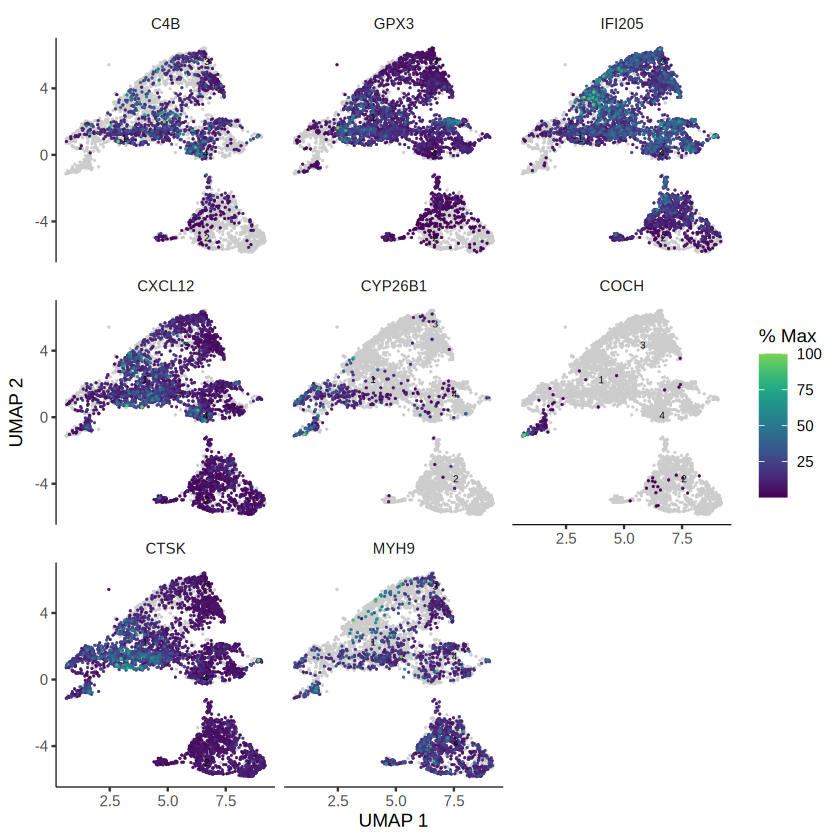

In [26]:
# tests 3
plot_cells(fibro, genes=c('C4B', 'GPX3', 'IFI205', 'CXCL12', 'CYP26B1',
                          'COCH', 'CTSK', 'MYH9'),
           show_trajectory_graph=FALSE)

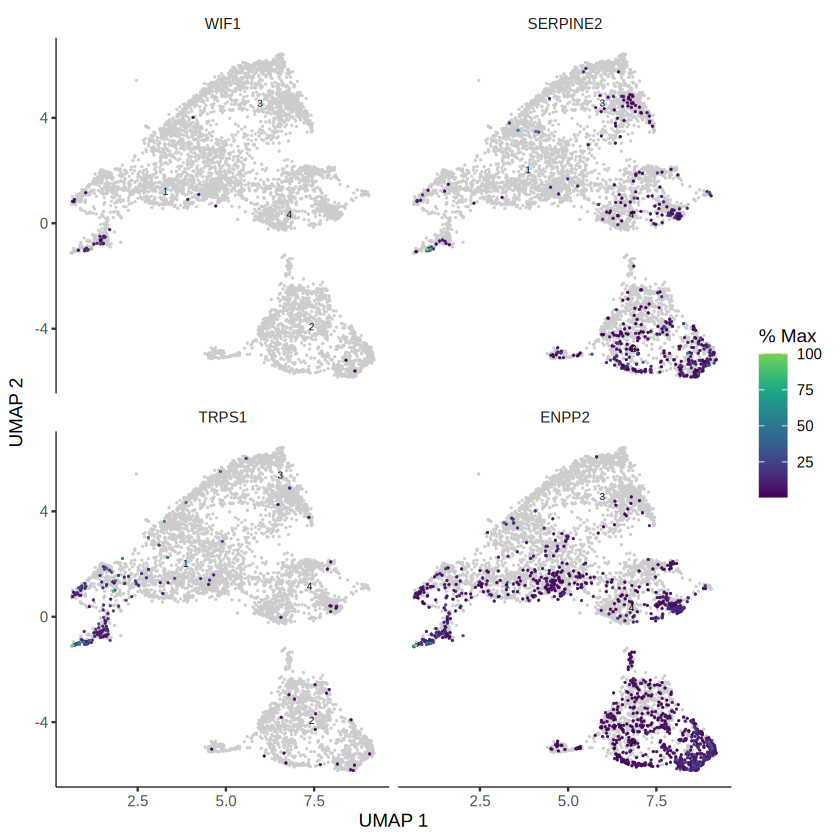

In [76]:
# tests 4
plot_cells(fibro, genes=c('WIF1', 'SERPINE2', 'TRPS1', 'ENPP2'),
           show_trajectory_graph=FALSE)

# Ko Fibroblast DEGs with Seurat

In [846]:
# convert to seurat obj
fibro_counts <- counts(fibro)
fibro_genes <- rownames(fibro)
fibro_cells <- colnames(fibro)
df <- data.frame(fibro_counts)
rownames(df) <- fibro_genes
colnames(df) <- fibro_cells
cell_meta <- colData(fibro)
cell_meta$cluster <- clusters(fibro)
cell_meta <- as.data.frame(cell_meta)
obj <- CreateSeuratObject(fibro_counts, meta.data=cell_meta)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [849]:
# get per-cluster DEGs
obj <- NormalizeData(obj)
Idents(obj) <- obj@meta.data$cluster
degs <- FindAllMarkers(obj)

Normalizing layer: counts

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4



In [853]:
head(degs)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene  
NID1   6.399383e-243 -1.325211  0.429 0.878 1.167183e-238 1       NID1  
PTGIS  5.962288e-241 -2.857327  0.035 0.472 1.087462e-236 1       PTGIS 
IGFBP4 1.151239e-228 -1.542861  0.120 0.592 2.099745e-224 1       IGFBP4
CXCL1  3.773503e-199 -1.752633  0.272 0.702 6.882491e-195 1       CXCL1 
CSRP2  4.786584e-197 -1.664277  0.291 0.717 8.730251e-193 1       CSRP2 
RBP1   1.807622e-187 -1.758134  0.132 0.547 3.296921e-183 1       RBP1

In [858]:
# filter, sort, and write out degs
filt_degs <- degs %>%
                filter(p_val_adj <= 0.01, abs(avg_log2FC) >= 0.5) %>%
                arrange(cluster, desc(avg_log2FC))
degs_out_path <- '/home/6j9/projects/atopic_dermatitis/data/seurat_degs/fibro_degs.tsv'
write.table(filt_degs, degs_out_path, quote=FALSE, sep='\t', row.names=FALSE)
# write out all DEGs for background
degs_background_out_path <- '/home/6j9/projects/atopic_dermatitis/data/seurat_degs/background.tsv'
writeLines(unique(filt_degs$gene), degs_background_out_path)

# Ko Fibroblast trajectory DEGs

In [629]:
fibro <- learn_graph(fibro, use_partition=TRUE)

  |======================================================================| 100%
  |======================================================================| 100%


Saving 7 x 7 in image


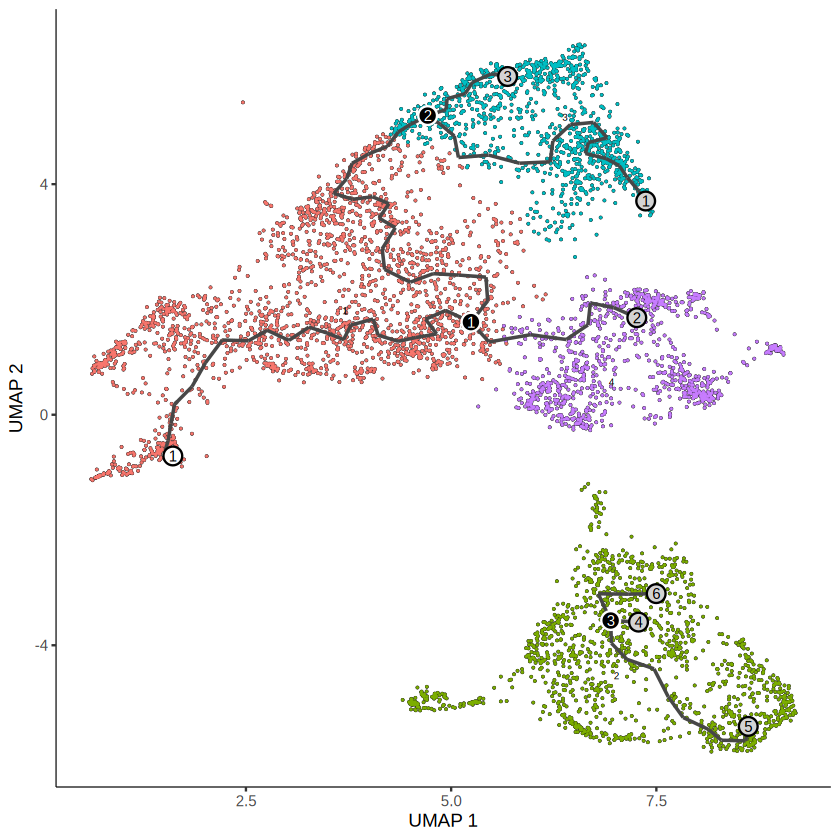

In [708]:
plot_cells(fibro, color_cells_by='cluster',
           label_principal_points=FALSE, graph_label_size=3)
ggsave(file.path(fibro_plot_dir, 'fibro_trajectories.png'))

In [649]:
fibro <- order_cells(fibro, root_pr_nodes=c('Y_1'))

In [632]:
fibro_traj_res <- graph_test(fibro, neighbor_graph='principal_graph',
                             cores=12)

  |=======================================================| 100%, Elapsed 01:16


In [633]:
fibro_degs <- subset(fibro_traj_res, q_value < 0.01)
fibro_deg_ids <- row.names(subset(fibro_traj_res, q_value < 0.01))

In [800]:
fibro_degs <- fibro_degs %>% arrange(desc(morans_test_statistic))
top_nine <- row.names(fibro_degs)[1:9]
top_36 <- row.names(fibro_degs)[1:36]

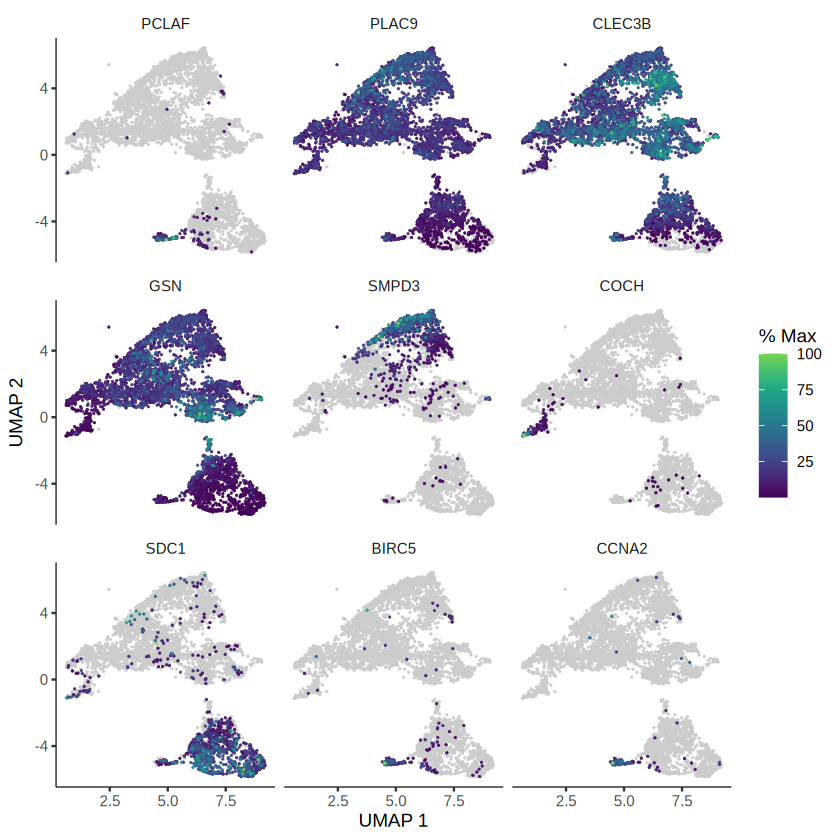

In [636]:
plot_cells(fibro, genes=top_nine, label_cell_groups=FALSE,
           show_trajectory_graph=FALSE)

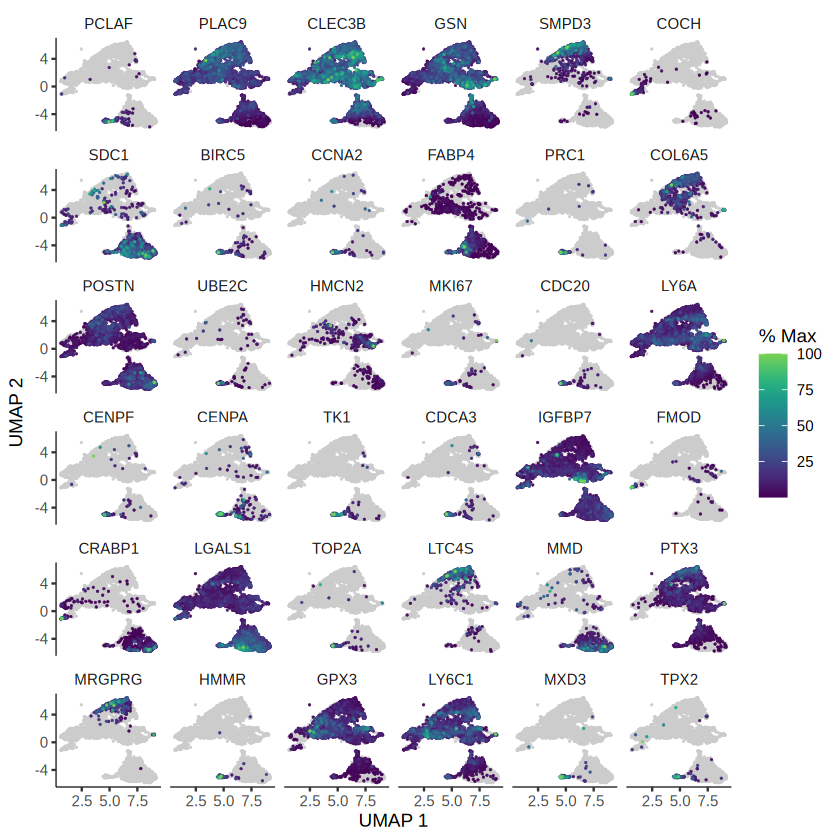

In [801]:
plot_cells(fibro, genes=top_36, label_cell_groups=FALSE,
           show_trajectory_graph=FALSE)

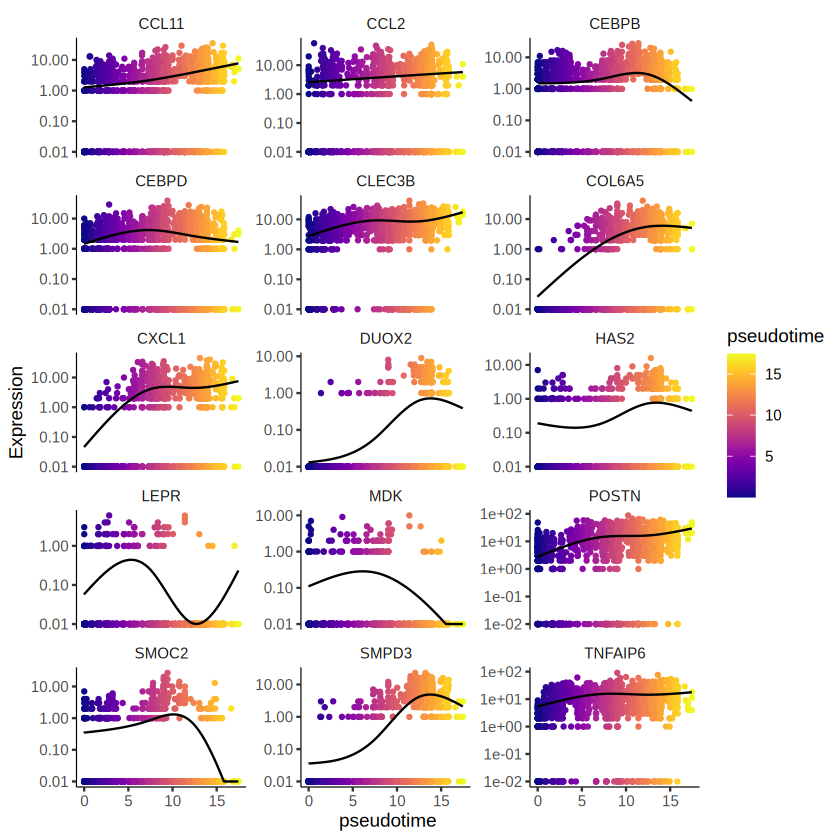

In [699]:
inf_genes <- c('COL6A5', 'CCL11', 'CEBPB', 'CEBPD', 'CXCL1', 'SMPD3',
               'CCL2', 'DUOX2', 'CLEC3B', 'LEPR', 'HAS2', 'TNFAIP6', 'POSTN',
               'MDK', 'SMOC2')
fibro_inf <- fibro[rownames(rowData(fibro)) %in% inf_genes,
                   colData(fibro)$condition == 'ad']
plot_genes_in_pseudotime(fibro_inf, min_expr=0.01, ncol=3)

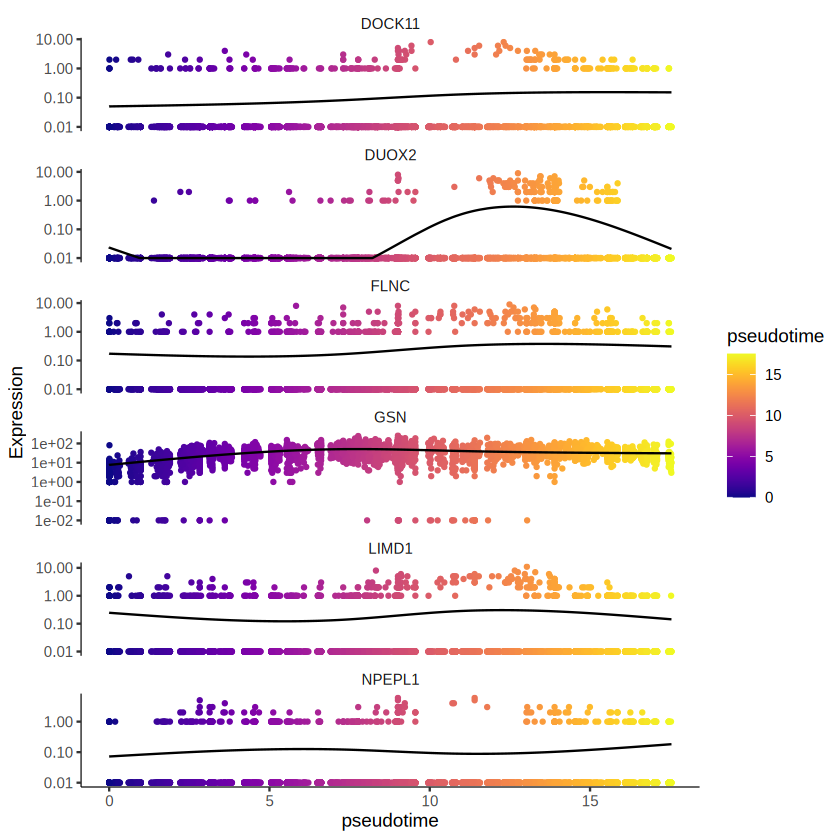

In [688]:
inf_genes <- c('DUOX2', 'LIMD1', 'DOCK11', 'GSN', 'FLNC', 'NPEPL1')
fibro_inf <- fibro[rownames(rowData(fibro)) %in% inf_genes, ]
plot_genes_in_pseudotime(fibro_inf, min_expr=0.01)

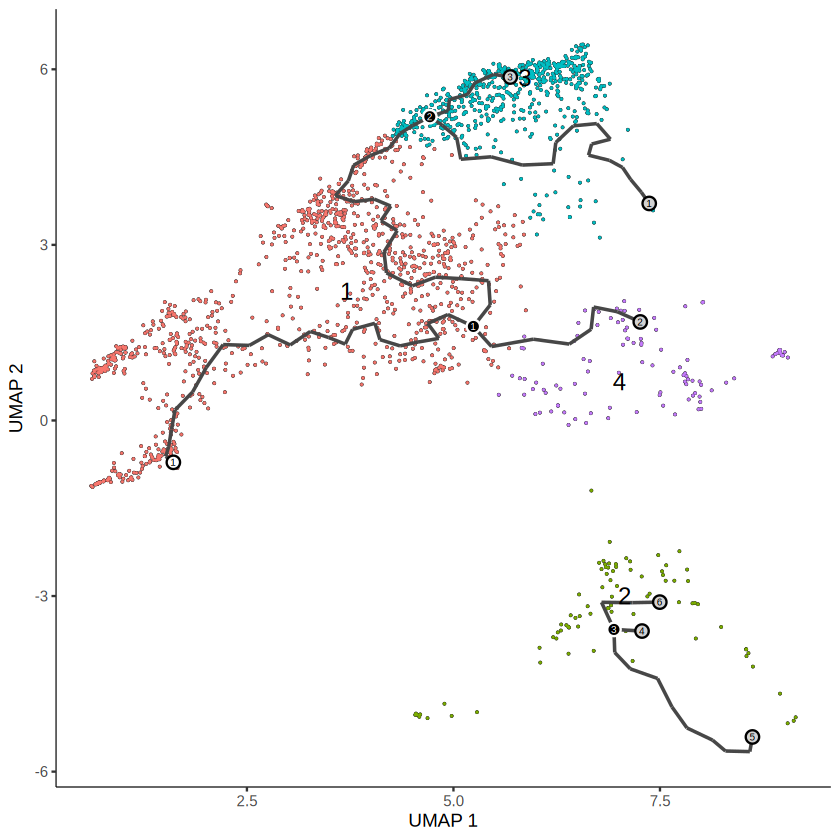

In [700]:
plot_cells(fibro_inf, color_cells_by='cluster', group_label_size=5)

# Ko Leukocytes

In [92]:
leuko_plot_dir <- file.path(plot_dir, 'cells/leukocytes')

In [93]:
leuko <- cds[, partitions(cds) %in% c('2')]

Saving 7 x 7 in image


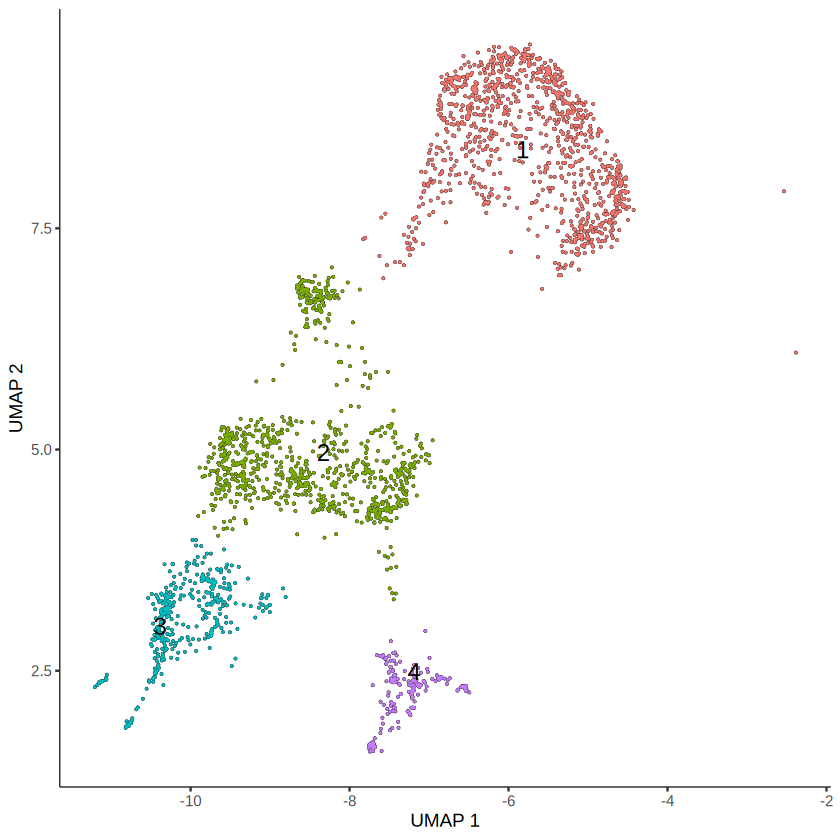

In [95]:
leuko <- cluster_cells(leuko, resolution=0.0003)
plot_cells(leuko, color_cells_by='cluster', group_label_size=5,
           show_trajectory_graph=FALSE)
ggsave(file.path(leuko_plot_dir, 'leuko_subclusters.png'))

Saving 7 x 7 in image


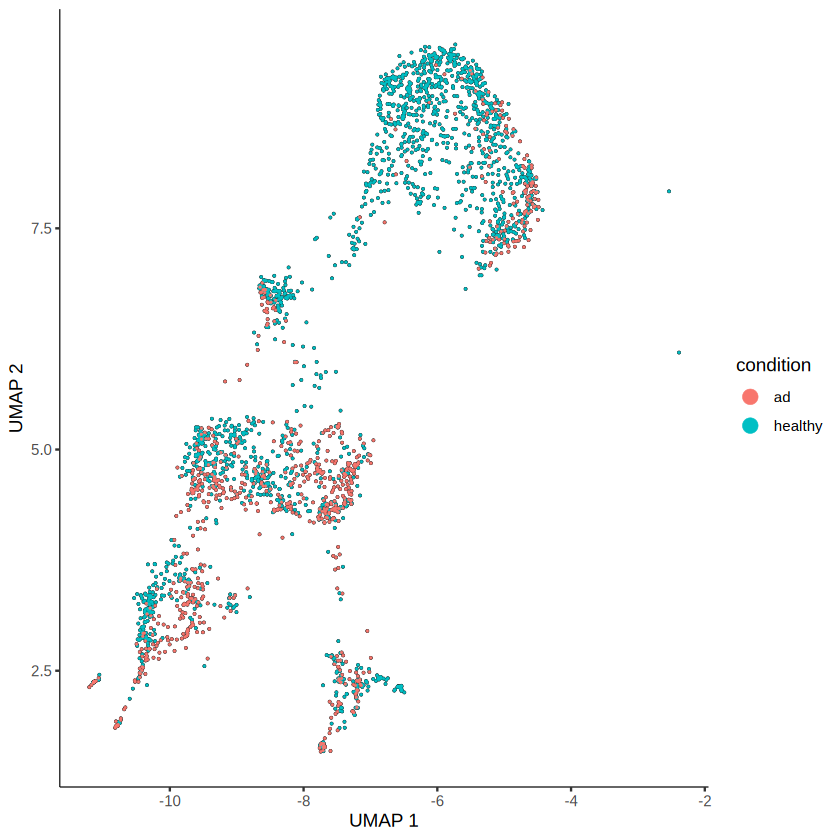

In [96]:
plot_cells(leuko, color_cells_by='condition', label_cell_groups=FALSE,
           show_trajectory_graph=FALSE)
ggsave(file.path(fibro_plot_dir, 'leuko_conditions.png'))

In [97]:
# get top marker genes per fibro cluster
markers <- top_markers(leuko, group_cells_by='cluster',
                       genes_to_test_per_group=1000, speedglm.maxiter=100,
                       reduction_method='UMAP', cores=12)

  |=======================================================| 100%, Elapsed 00:01
  |=======================================================| 100%, Elapsed 00:19


In [108]:
leuko_markers <- markers %>%
                    filter(specificity >= 0.5) %>%
                    #filter(fraction_expressing >= .9) %>%
                    group_by(cell_group) %>%
                    #top_n(16, mean_expression)
                    top_n(16, pseudo_R2)
marker_ids <- unique(leuko_markers$gene_id)

In [109]:
out_path <- file.path(leuko_plot_dir, 'leuko_genes_dotplot.png')
plot <- plot_genes_by_group(leuko,
                            markers=c(marker_ids),
                            group_cells_by='cluster',
                            ordering_type='cluster_row_col',
                            max.size=5)
ggsave(out_path, plot, width=8, height=12)

In [110]:
colData(leuko)$cluster_cell_type <- as.character(clusters(leuko))
colData(leuko)$cluster_cell_type <- dplyr::recode(colData(leuko)$cluster_cell_type,
                                                  '1'='M2-like macrophages',
                                                  '2'='Tissue-resident macrophages',
                                                  '3'='Dendritic cells',
                                                  '4'='Proliferating macrophages')

In [111]:
# merge these fibroblast subtypes with the original cds
colData(cds)[colnames(leuko), ]$subclustered_cell_type <- colData(leuko)$cluster_cell_type

No trajectory to plot. Has learn_graph() been called yet?



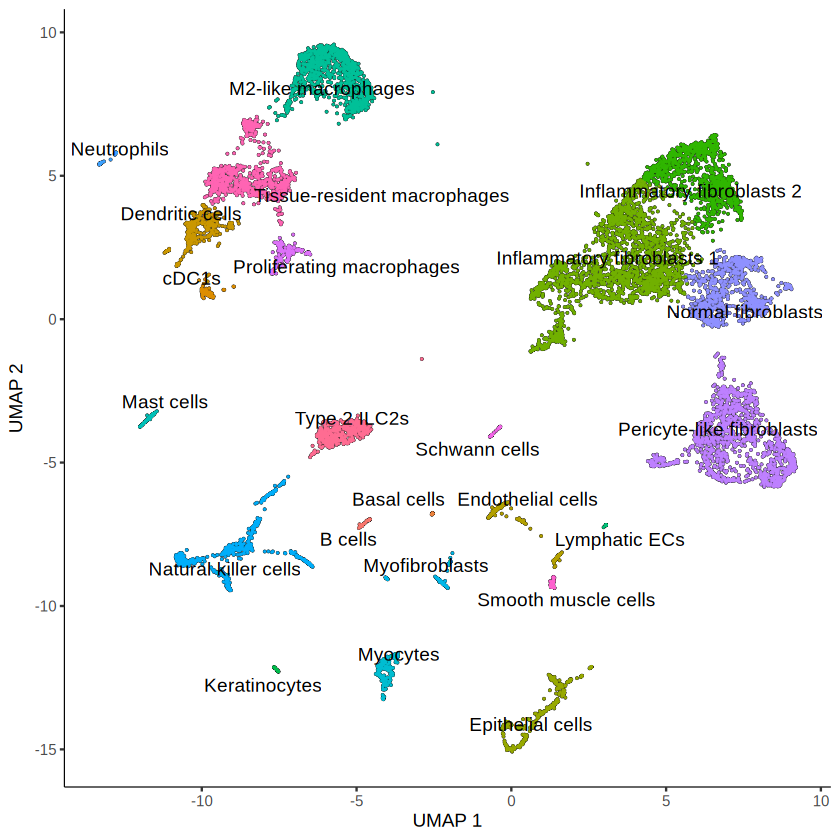

In [113]:
plot_cells(cds, color_cells_by='subclustered_cell_type', group_cells_by='partition',
           group_label_size=4, labels_per_group=4)
ggsave(file.path(plot_dir, 'cells/cell-typed_partition-subclusters.png'), width=8, height=8)

# He preprocessing

In [6]:
mtx_dir <- '/home/6j9/projects/atopic_dermatitis/data/count_matrices/he'
#conditions <- c('healthy', 'healthy', 'ad', 'ad', 'ad')

In [9]:
cds <- create_cds_from_10x_dir(mtx_dir)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.4 GiB”


In [14]:
# gotta fix samples and conditions stuff

In [7]:
# cluster using monocle3
cds <- preprocess_cds(cds, num_dim=50, norm_method='log')
cds <- align_cds(cds, num_dim=100, alignment_group='sample')
cds <- reduce_dimension(cds, max_components=2, reduction_method='UMAP')

Aligning cells from different batches using Batchelor.
Please remember to cite:
	 Haghverdi L, Lun ATL, Morgan MD, Marioni JC (2018). 'Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.' Nat. Biotechnol., 36(5), 421-427. doi: 10.1038/nbt.4091

No preprocess_method specified, and aligned coordinates have been computed previously. Using preprocess_method = 'Aligned'



No trajectory to plot. Has learn_graph() been called yet?

Saving 7 x 7 in image


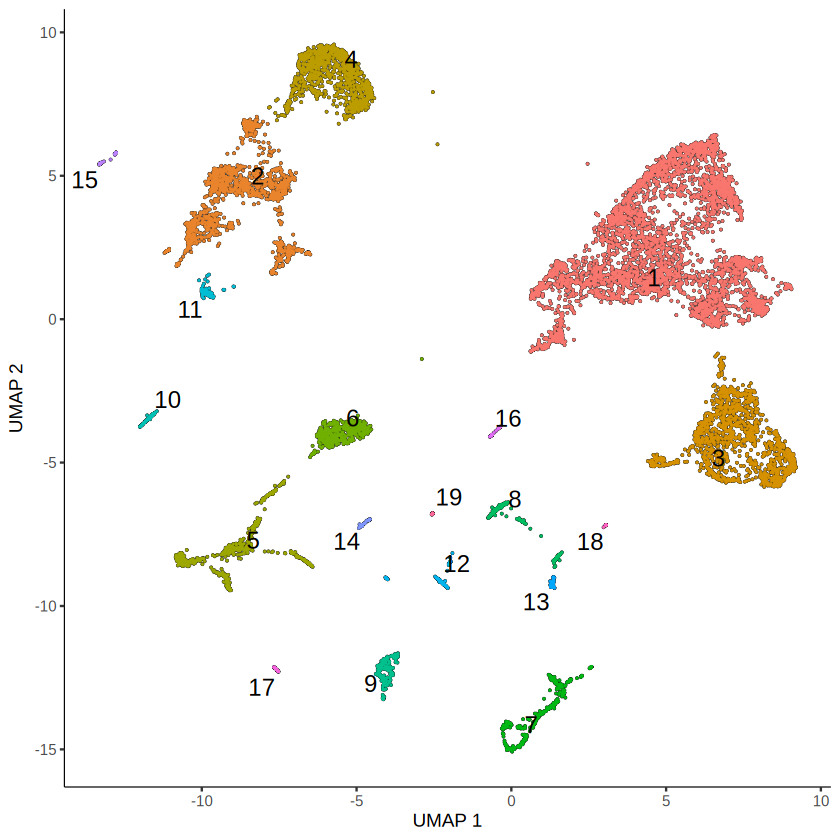

In [8]:
cds <- cluster_cells(cds, reduction_method='UMAP', cluster_method='leiden', resolution=0.00001)
plot_cells(cds, group_label_size=5)
ggsave(file.path(plot_dir, 'cells/clusters.png'))